# Notebook sur l'homograghie

Dans ce notebook, on va voir comment utiliser un objet dont on connait ses réelles dimensions pour appliquer une homographie et générer de nouvelles images d'un point de vue différent à l'aide de projections

**Plan:**
1. Récupération des points de référence
2. Homographie
3. Première méthode d'estimation de la distance entre les joueurs et la table

### 0. Import

In [99]:
import cv2
import os
import subprocess
import json
import pandas as pd
import csv
import ipywidgets
#from IPython.display import Image, display
import IPython.display
import PIL
from ipyfilechooser import FileChooser
from moviepy.editor import VideoFileClip

### 1. Récupération des points de référence

On affiche une image sur laquelle on va sélectionner les 4 coins de la table.
(Les fonctions pour l'homographie utiliseront les 4 derniers cliques comme coin de la table)
L'ordre dans lequel on annote les coins de la table est important

<img src="utils/ordre_annotation_coins_table.PNG" width=300 height=300 />

In [101]:

#Selection de l'image

from ipyfilechooser import FileChooser
import os

# Create new FileChooser:
# Path: current directory
# File: test.txt
# Title: <b>FileChooser example</b>
# Show hidden files: no
# Use the default path and filename as selection: yes
# Only show folders: no
fdialog = FileChooser(
    os.getcwd(),
    filename='test.txt',
    title='<b>FileChooser example</b>',
    show_hidden=False,
    select_default=True,
    show_only_dirs=False
)

display(fdialog)

# Get the selected value
fdialog.selected

# Callback example
def change_title(chooser):
    chooser.title = '<b>Sélection effectuée</b>'

# Register callback function
fdialog.register_callback(change_title)

# Set or change the title
fdialog.title = '<b>Selectionner une image</b>'

# Show hidden files, change rows to 10, and hide folder icons
fdialog.show_hidden = True
fdialog.rows = 10
fdialog.dir_icon = None

# Change folder icon to `os.sep` and append it to the folder name
fdialog.dir_icon = os.sep
fdialog.dir_icon_append = True



# Switch to folder-only mode
fdialog.show_only_dirs = True

# Switch back to standard mode
fdialog.show_only_dirs = False


# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fdialog.filter_pattern = ['*.jpg', '*.png']

# Change the default path and filename
fdialog.default_path = os.path.abspath(os.getcwd())
fdialog.default_filename = 'readme.md'

# Reset to defaults and clear the selected value
fdialog.reset()




FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

<IPython.core.display.Javascript object>


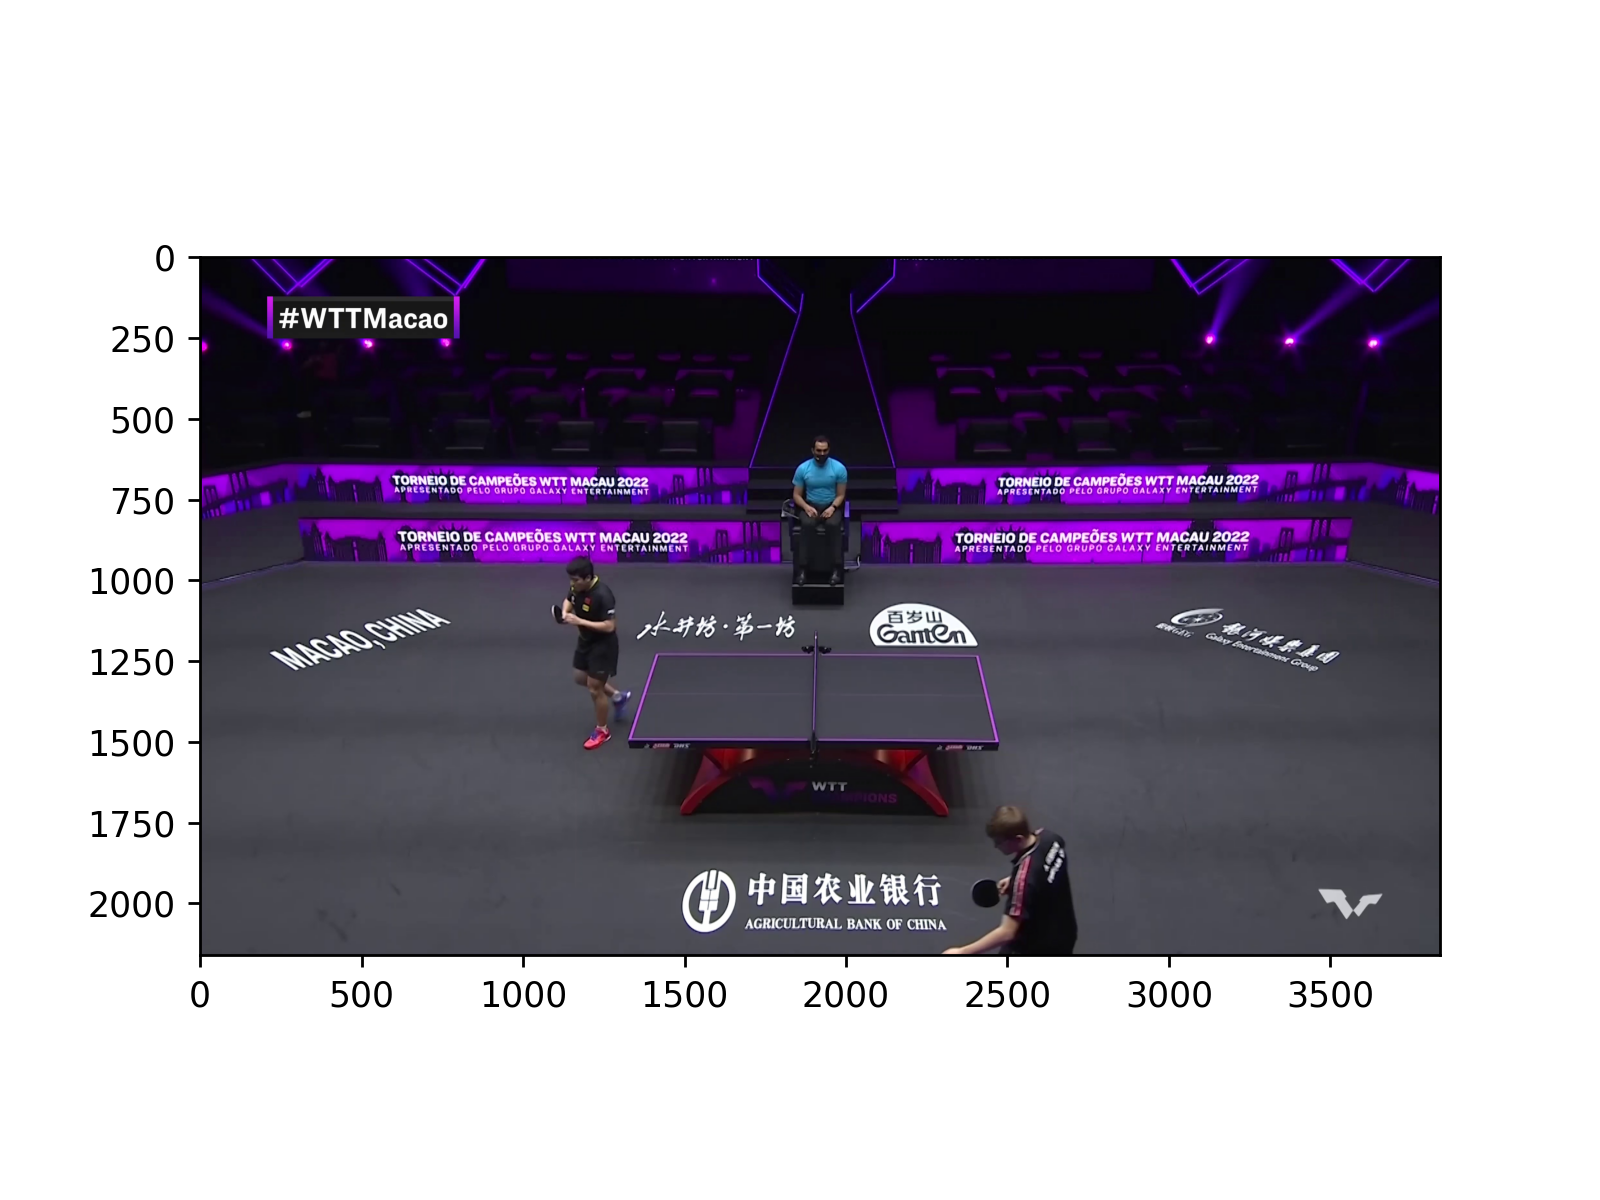

In [111]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets

chemin_image = fdialog.selected#os.path.join('test','1th_frame.jpg') #A DEFINIR

if ((os.path.isfile(chemin_image)) and (os.path.split(chemin_image)[-1][-4:] in ['.jpg', '.png'])):
    
    # Create a random image
    a = np.random.poisson(size=(12,15))
    fig = plt.figure()
    plt.imshow(cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB))

    # Create and display textarea widget
    txt = wdg.Textarea(
        value='',
        placeholder='',
        description='event:',
        disabled=False
    )
    liste_points = []
    # Define a callback function that will update the textarea
    def onclick(event):
        txt.value = str(event)  # Dynamically update the text box above
        liste_points.append(str(event).split('xydata=(')[1].split(')')[0].replace(' ',''))

    # Create an hard reference to the callback not to be cleared by the garbage collector
    ka = fig.canvas.mpl_connect('button_press_event', onclick)
    
else:
    print('Ce n\'est pas une image qui a été choisie')

### 1. Homographie

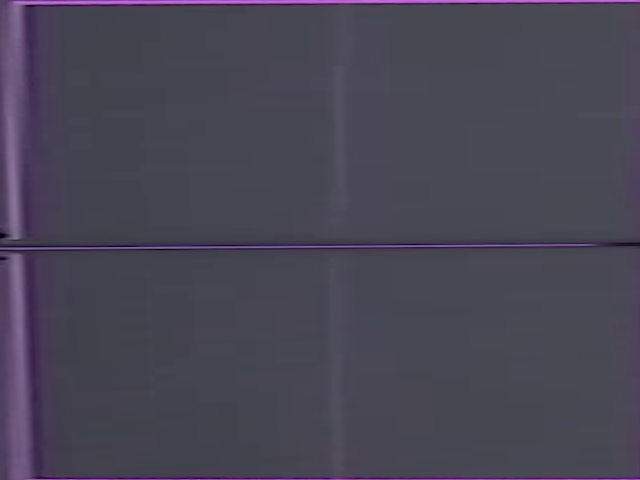

In [136]:
#Récupération des coordonnées des points

def homographie_image(chemin_image,dossier_sauvegarder,liste_points,afficher_image=True):
    if not os.path.isdir(dossier_sauvegarder):
        os.mkdir(dossier_sauvegarder)
    if len(liste_points) >= 4:
        pt1 = [int(float(liste_points[-4].split(',')[0])),int(float(liste_points[-4].split(',')[1]))]
        pt2 = [int(float(liste_points[-3].split(',')[0])),int(float(liste_points[-3].split(',')[1]))]
        pt3 = [int(float(liste_points[-2].split(',')[0])),int(float(liste_points[-2].split(',')[1]))]
        pt4 = [int(float(liste_points[-1].split(',')[0])),int(float(liste_points[-1].split(',')[1]))]
        
        img = cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB)
        pts_src = np.float32([[pt1[0],pt1[1]],[pt2[0],pt2[1]],[pt3[0],pt3[1]],[pt4[0],pt4[1]]]).reshape(-1,1,2)
        pts_dst = np.float32([[0,0],[640,0],[640,480],[0,480]]).reshape(-1,1,2) #On choisi les points de destination de tel sorte à avoir une vude du dessus où 1cm = 1pixel
        H = cv2.getPerspectiveTransform(pts_src, pts_dst)
        img = cv2.warpPerspective(img, H, (640,480))
        if afficher_image:
            IPython.display.display(PIL.Image.fromarray(img))
        cv2.imwrite(os.path.join(dossier_sauvegarder,os.path.split(chemin_image)[1]),img)
        
        
homographie_image(os.path.join('output','frames','0.jpg'),os.path.join('output','homographie'),liste_points)

### Enregistrer vidéo homographie

In [130]:
#Sauvegarder les images de toutes les homographies
chemin_images = os.path.join('output','frames')
liste_images = os.listdir(chemin_images)
for i in range(len(liste_images)):
    homographie_image(os.path.join('output','frames',str(i)+'.jpg'),os.path.join('output','homographie'),liste_points,False)
    
#Enregistrer une vidéo à l'aide des images
def enregistrer_video_d_images(chemin_images,nom_video):
    
    liste_images_homographie = os.listdir(chemin_images)
    liste_images_homographie.sort()
    liste_images_homographie.sort(key=len)
    
    if not os.path.isdir('video'):
        os.mkdir('video')
    size = cv2.imread(os.path.join(chemin_images,'1.jpg')).shape
    fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
    videoWriter = cv2.VideoWriter(os.path.join('video',nom_video), fourcc, 30.0, (size[1],size[0]))
    for img in liste_images_homographie:
        frame = cv2.imread(os.path.join(chemin_images,img))
        videoWriter.write(frame)
    videoWriter.release()
    
enregistrer_video_d_images(os.path.join('output','homographie'),'homographie.avi')

### Visualiser la vidéo

In [132]:

#Selection de l'image

from ipyfilechooser import FileChooser
import os

# Create new FileChooser:
# Path: current directory
# File: test.txt
# Title: <b>FileChooser example</b>
# Show hidden files: no
# Use the default path and filename as selection: yes
# Only show folders: no
fdialog_vid = FileChooser(
    os.getcwd(),
    filename='test.txt',
    title='<b>FileChooser example</b>',
    show_hidden=False,
    select_default=True,
    show_only_dirs=False
)

display(fdialog_vid)

# Get the selected value
fdialog_vid.selected

# Callback example
def change_title(chooser):
    chooser.title = '<b>Sélection effectuée</b>'

# Register callback function
fdialog_vid.register_callback(change_title)

# Set or change the title
fdialog_vid.title = '<b>Selectionner une vidéo</b>'

# Show hidden files, change rows to 10, and hide folder icons
fdialog_vid.show_hidden = True
fdialog_vid.rows = 10
fdialog_vid.dir_icon = None

# Change folder icon to `os.sep` and append it to the folder name
fdialog_vid.dir_icon = os.sep
fdialog_vid.dir_icon_append = True



# Switch to folder-only mode
fdialog_vid.show_only_dirs = True

# Switch back to standard mode
fdialog_vid.show_only_dirs = False


# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fdialog_vid.filter_pattern = ['*.mp4', '*.avi']

# Change the default path and filename
fdialog_vid.default_path = os.path.abspath(os.getcwd())
fdialog_vid.default_filename = 'readme.md'

# Reset to defaults and clear the selected value
fdialog_vid.reset()




FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

In [135]:
clip = VideoFileClip(fdialog_vid.selected)
clip.ipython_display(width=600)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
